# 10 — Final Report & Visualizations

**Goal:** End-to-end summary of the football player market value prediction project.

**Inputs:** All figures from `../figures/` · `../data/processed/` outputs · `../models/`

---
## Project Summary

**Task:** Predict `market_value_in_eur` from Transfermarkt data using separate models per position group (GK / DEF / MID / ATT).

**Pipeline:** 7 raw CSVs → cleaning & merging → EDA → feature engineering → preprocessing → linear baseline → XGBoost / RF / MLP → SHAP interpretation → undervalued players & dream team

**Data:** 33,524 players · 449K valuation records · 1.7M appearances · 14 leagues

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import json, os, pickle, warnings
warnings.filterwarnings('ignore')

PROC_PATH    = '../data/processed/'
MODELS_PATH  = '../models/'
FIGURES_PATH = '../figures/'
POSITIONS    = ['GK', 'DEF', 'MID', 'ATT']

def show_fig(path, title=None, figsize=None):
    if not os.path.exists(path):
        print(f'Not found: {path}'); return
    img = mpimg.imread(path)
    h, w = img.shape[:2]
    fs = figsize or (min(w/100, 18), min(h/100, 10))
    fig, ax = plt.subplots(figsize=fs)
    ax.imshow(img); ax.axis('off')
    if title: ax.set_title(title, fontsize=11, fontweight='bold', pad=8)
    plt.tight_layout(pad=0); plt.show()

print('Ready.')

Ready.


---
## 1. Final Model Results

In [2]:
with open(PROC_PATH + 'baseline_results.json') as f: br = json.load(f)
with open(PROC_PATH + 'advanced_results.json') as f: ar = json.load(f)

rows = []
for pos in POSITIONS:
    base_r2   = max(br[pos][m]['test']['R2']       for m in br[pos])
    base_rmse = min(br[pos][m]['test']['RMSE_EUR_M'] for m in br[pos])
    adv = ar[pos]['best']
    rows.append({'Position': pos, 'Best Model': adv['name'],
                 'Baseline R2': base_r2, 'Final R2': adv['test']['R2'],
                 'R2 Gain': round(adv['test']['R2'] - base_r2, 3),
                 'RMSE log': adv['test']['RMSE'], 'RMSE EUR M': adv['test']['RMSE_EUR_M']})

results_df = pd.DataFrame(rows)
print('Final Model Performance')
print('=' * 70)
print(results_df.to_string(index=False))
print(f'\nMean R2: {results_df["Final R2"].mean():.3f}  '
      f'Mean gain: +{results_df["R2 Gain"].mean():.3f}')

Final Model Performance
Position   Best Model  Baseline R2  Final R2  R2 Gain  RMSE log  RMSE EUR M
      GK      XGBoost       0.7124    0.7923    0.080    0.6342       1.877
     DEF RandomForest       0.7640    0.8260    0.062    0.6358       1.987
     MID      XGBoost       0.7706    0.8287    0.058    0.6593       3.988
     ATT      XGBoost       0.7504    0.8070    0.057    0.6858       3.088

Mean R2: 0.814  Mean gain: +0.064


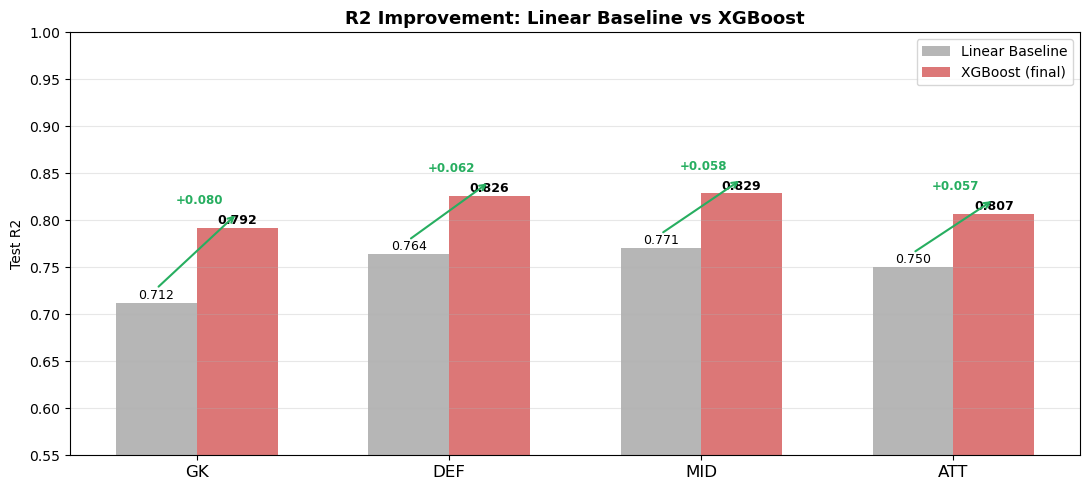

In [3]:
fig, ax = plt.subplots(figsize=(11, 5))
x, w = np.arange(len(POSITIONS)), 0.32
base  = results_df['Baseline R2'].values
final = results_df['Final R2'].values

b1 = ax.bar(x - w/2, base,  w, label='Linear Baseline', color='#AAAAAA', alpha=0.85)
b2 = ax.bar(x + w/2, final, w, label='XGBoost (final)',  color='#D65F5F', alpha=0.85)
for bar, v in zip(b1, base):  ax.text(bar.get_x()+bar.get_width()/2, v+0.004, f'{v:.3f}', ha='center', fontsize=9)
for bar, v in zip(b2, final): ax.text(bar.get_x()+bar.get_width()/2, v+0.004, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')
for i,(b,f) in enumerate(zip(base,final)):
    ax.annotate('', xy=(x[i]+w/2, f+0.015), xytext=(x[i]-w/2, b+0.015),
                arrowprops=dict(arrowstyle='->', color='#27ae60', lw=1.5))
    ax.text(x[i]+0.01, max(b,f)+0.025, f'+{f-b:.3f}',
            ha='center', fontsize=8.5, color='#27ae60', fontweight='bold')

ax.set_xticks(x); ax.set_xticklabels(POSITIONS, fontsize=12)
ax.set_ylabel('Test R2'); ax.set_ylim(0.55, 1.0)
ax.set_title('R2 Improvement: Linear Baseline vs XGBoost', fontsize=13, fontweight='bold')
ax.legend(fontsize=10); ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_PATH + '10_r2_improvement.png')
plt.show()

---
## 2. Exploratory Data Analysis

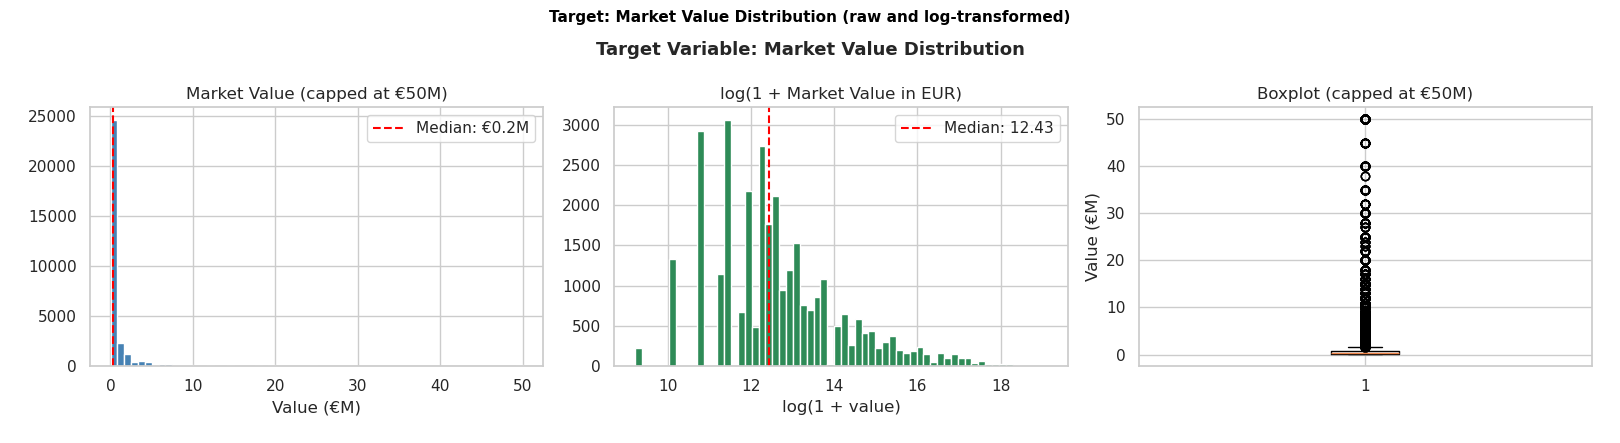

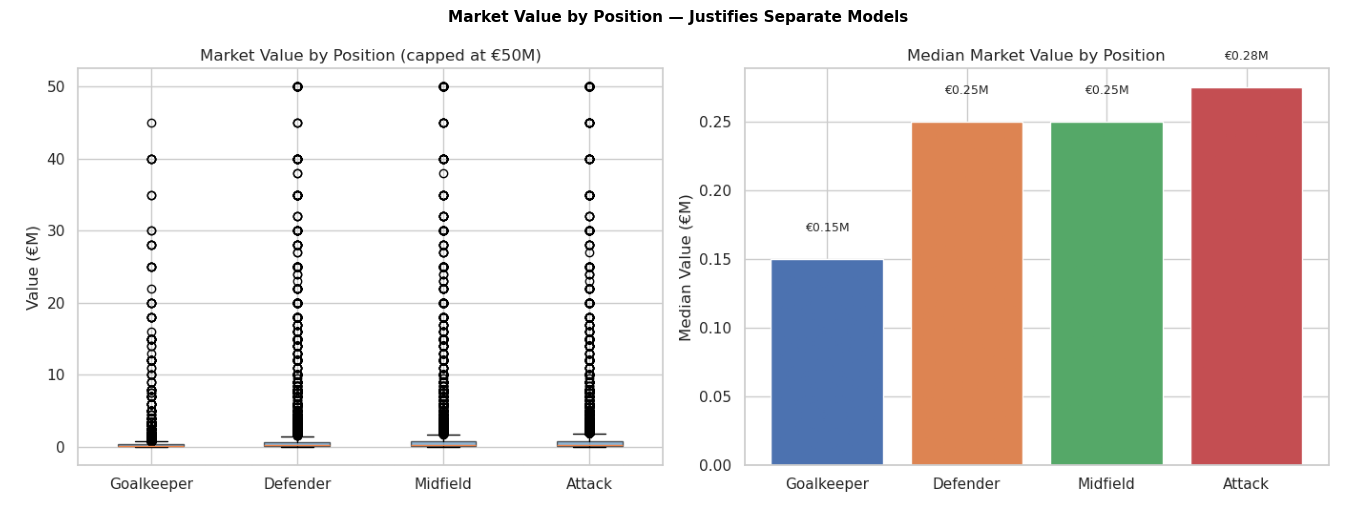

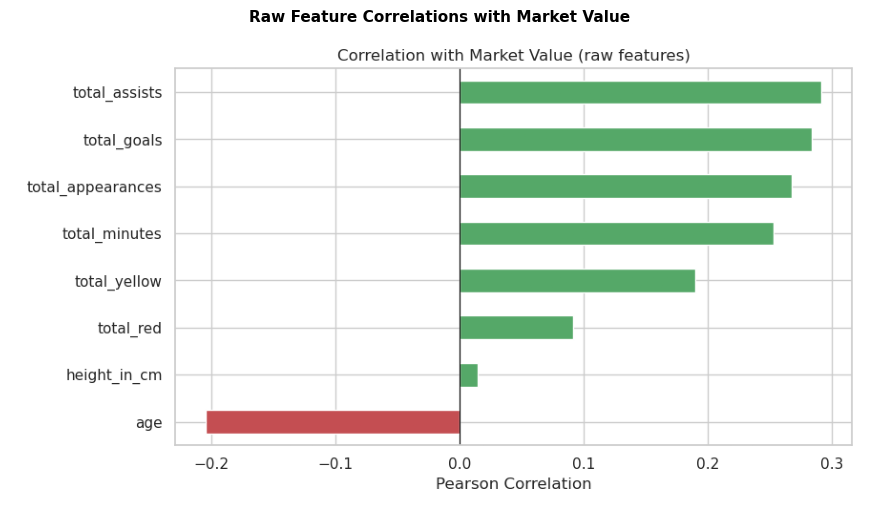

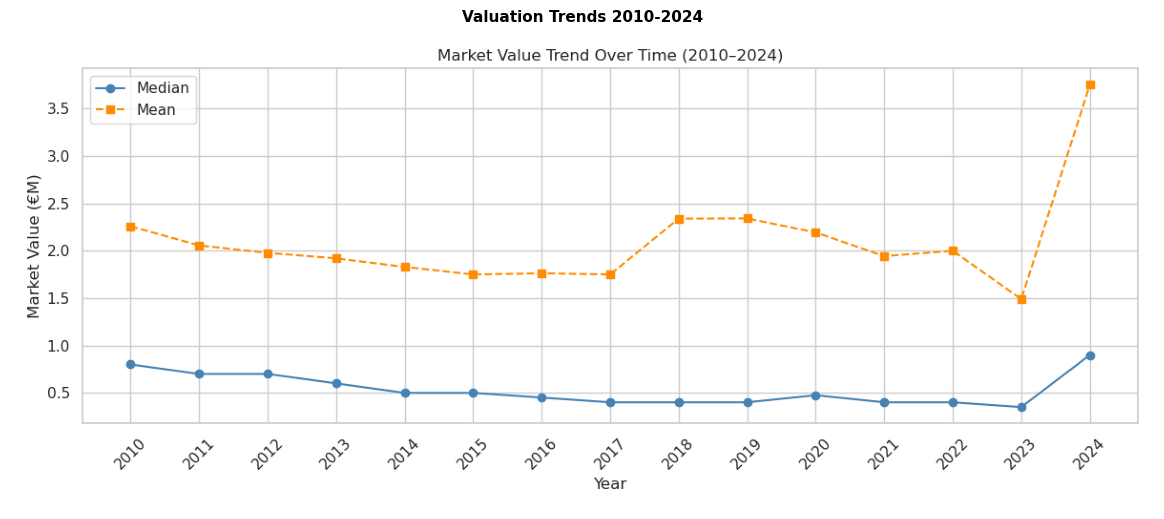

In [4]:
show_fig(FIGURES_PATH + '02_target_distribution.png',
         'Target: Market Value Distribution (raw and log-transformed)', figsize=(16, 5))
show_fig(FIGURES_PATH + '02_value_by_position.png',
         'Market Value by Position — Justifies Separate Models', figsize=(14, 5))
show_fig(FIGURES_PATH + '02_correlations.png',
         'Raw Feature Correlations with Market Value', figsize=(14, 5))
show_fig(FIGURES_PATH + '02_valuations_over_time.png',
         'Valuation Trends 2010-2024', figsize=(14, 5))

---
## 3. Feature Engineering

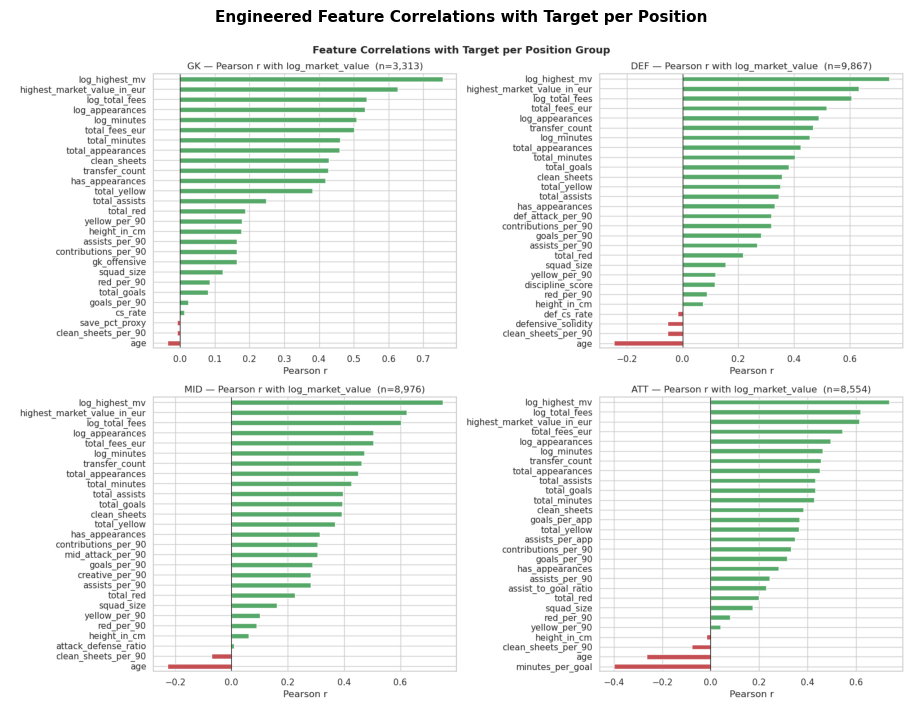

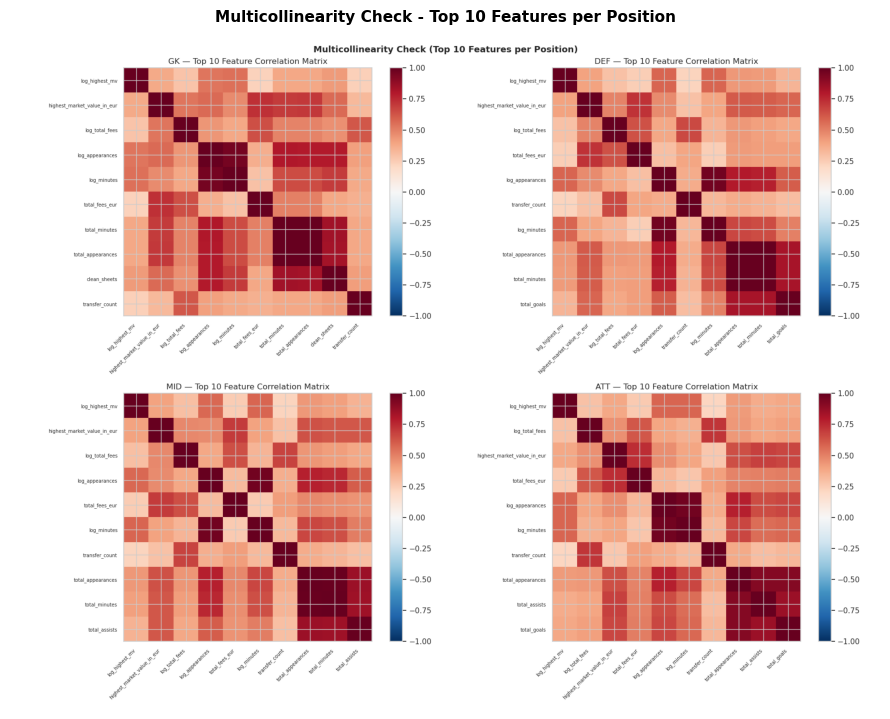

In [5]:
show_fig(FIGURES_PATH + '04_feature_correlations.png',
         'Engineered Feature Correlations with Target per Position', figsize=(18, 7))
show_fig(FIGURES_PATH + '04_multicollinearity.png',
         'Multicollinearity Check - Top 10 Features per Position', figsize=(18, 7))

---
## 4. Baseline vs Advanced Models

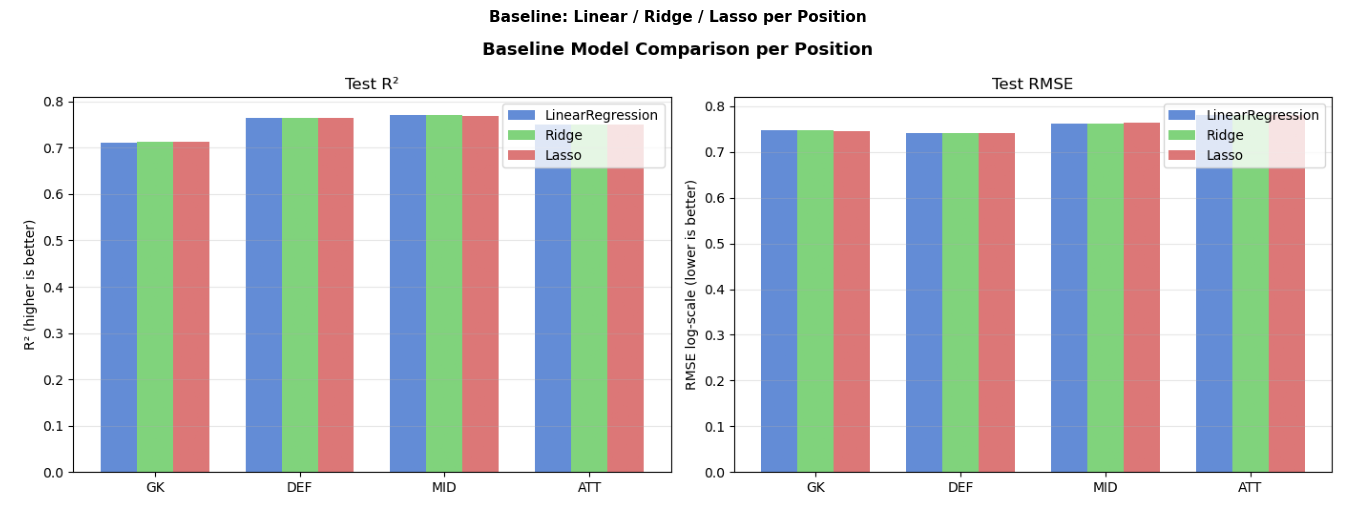

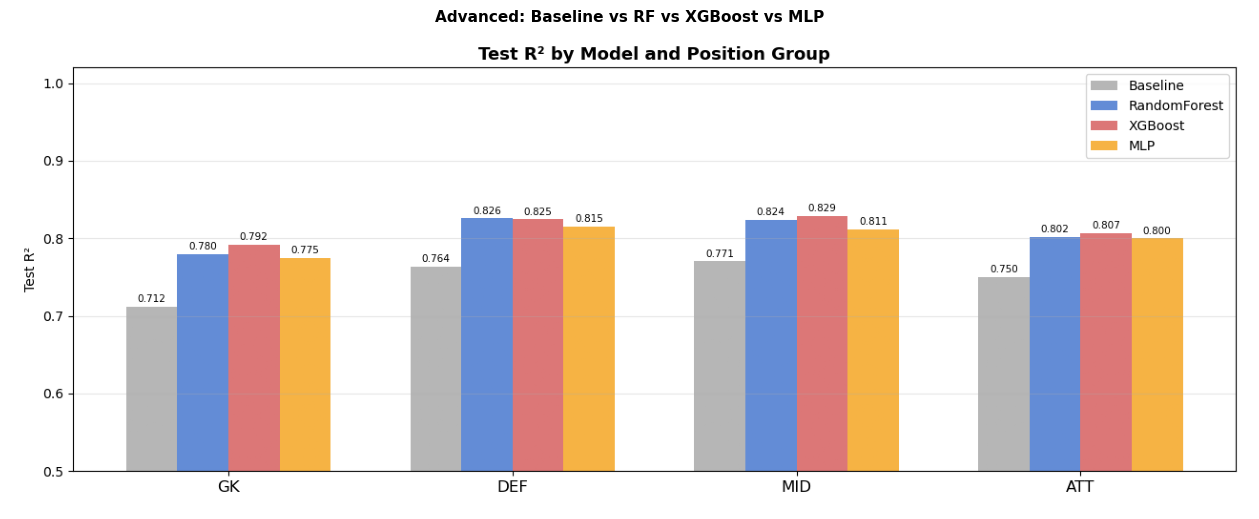

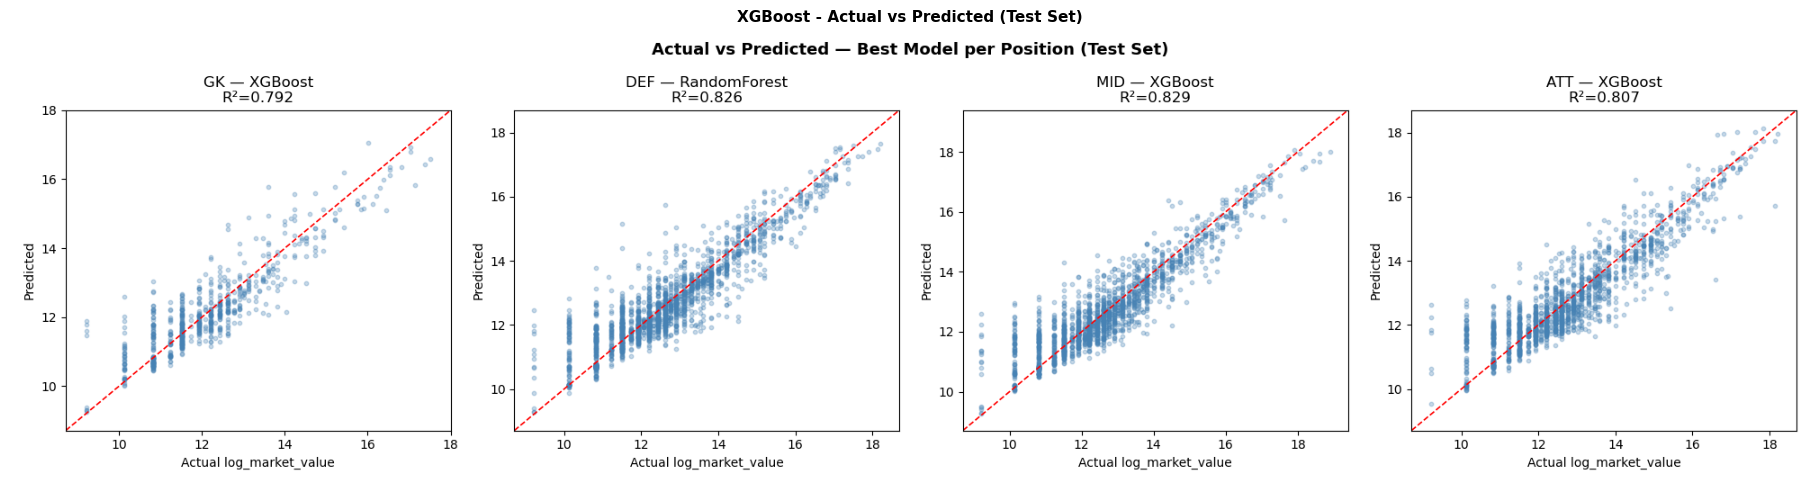

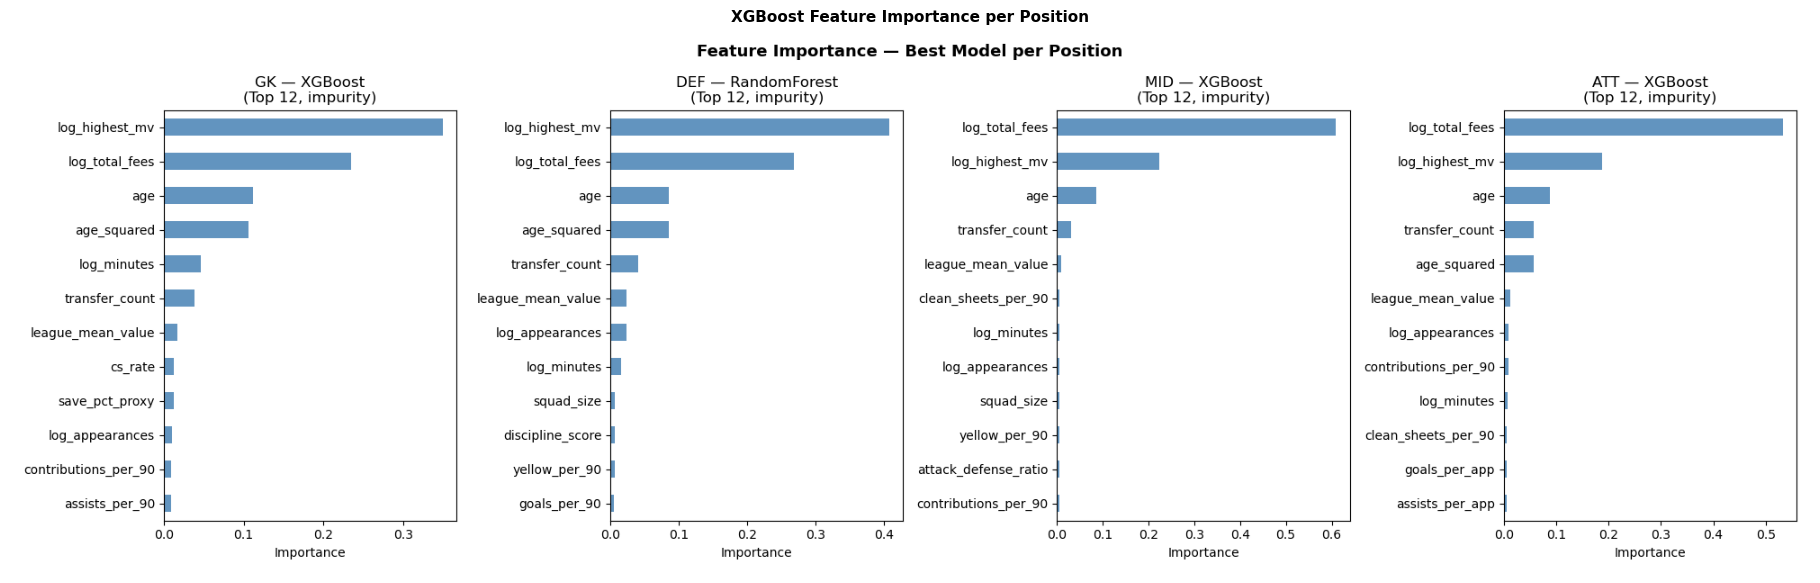

In [6]:
show_fig(FIGURES_PATH + '06_baseline_comparison.png',
         'Baseline: Linear / Ridge / Lasso per Position', figsize=(14, 5))
show_fig(FIGURES_PATH + '07_r2_comparison.png',
         'Advanced: Baseline vs RF vs XGBoost vs MLP', figsize=(14, 5))
show_fig(FIGURES_PATH + '07_actual_vs_predicted.png',
         'XGBoost - Actual vs Predicted (Test Set)', figsize=(18, 5))
show_fig(FIGURES_PATH + '07_feature_importance.png',
         'XGBoost Feature Importance per Position', figsize=(18, 6))

---
## 5. SHAP — Model Interpretation

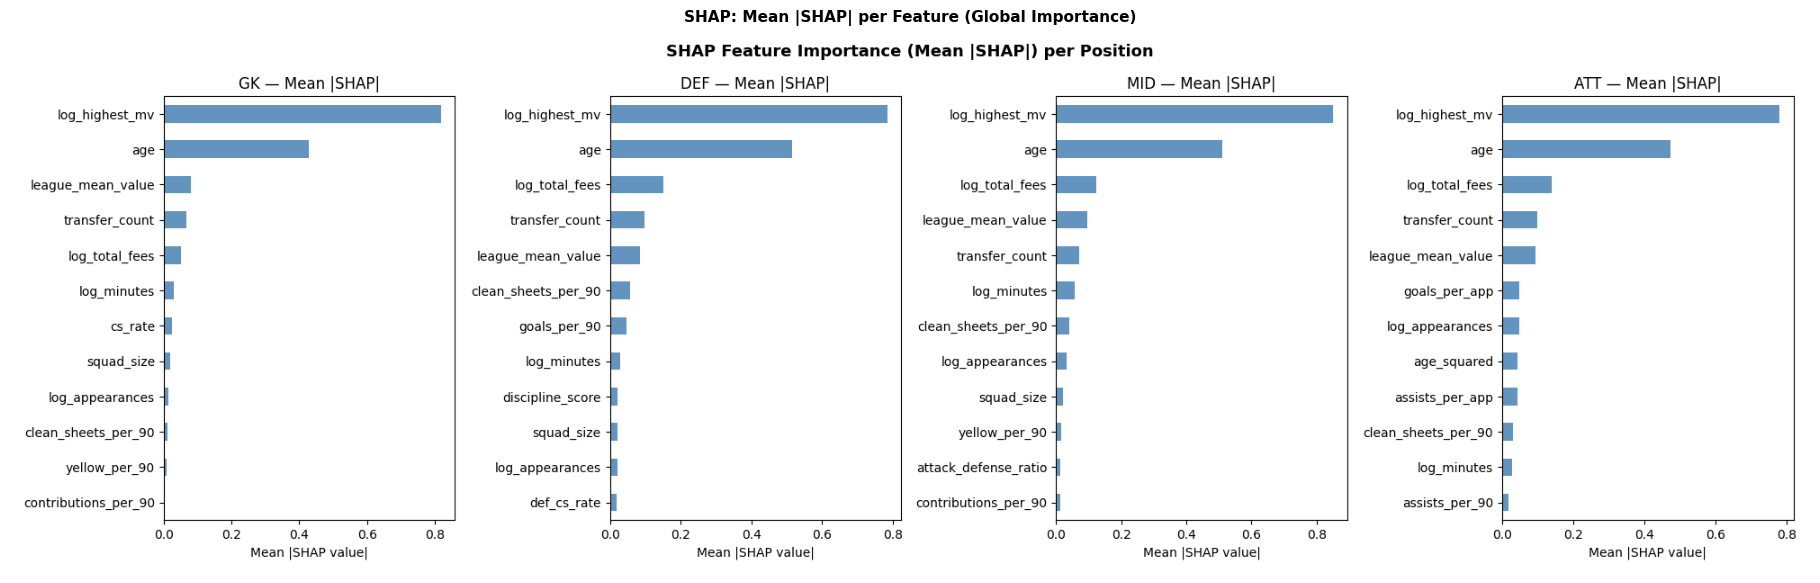

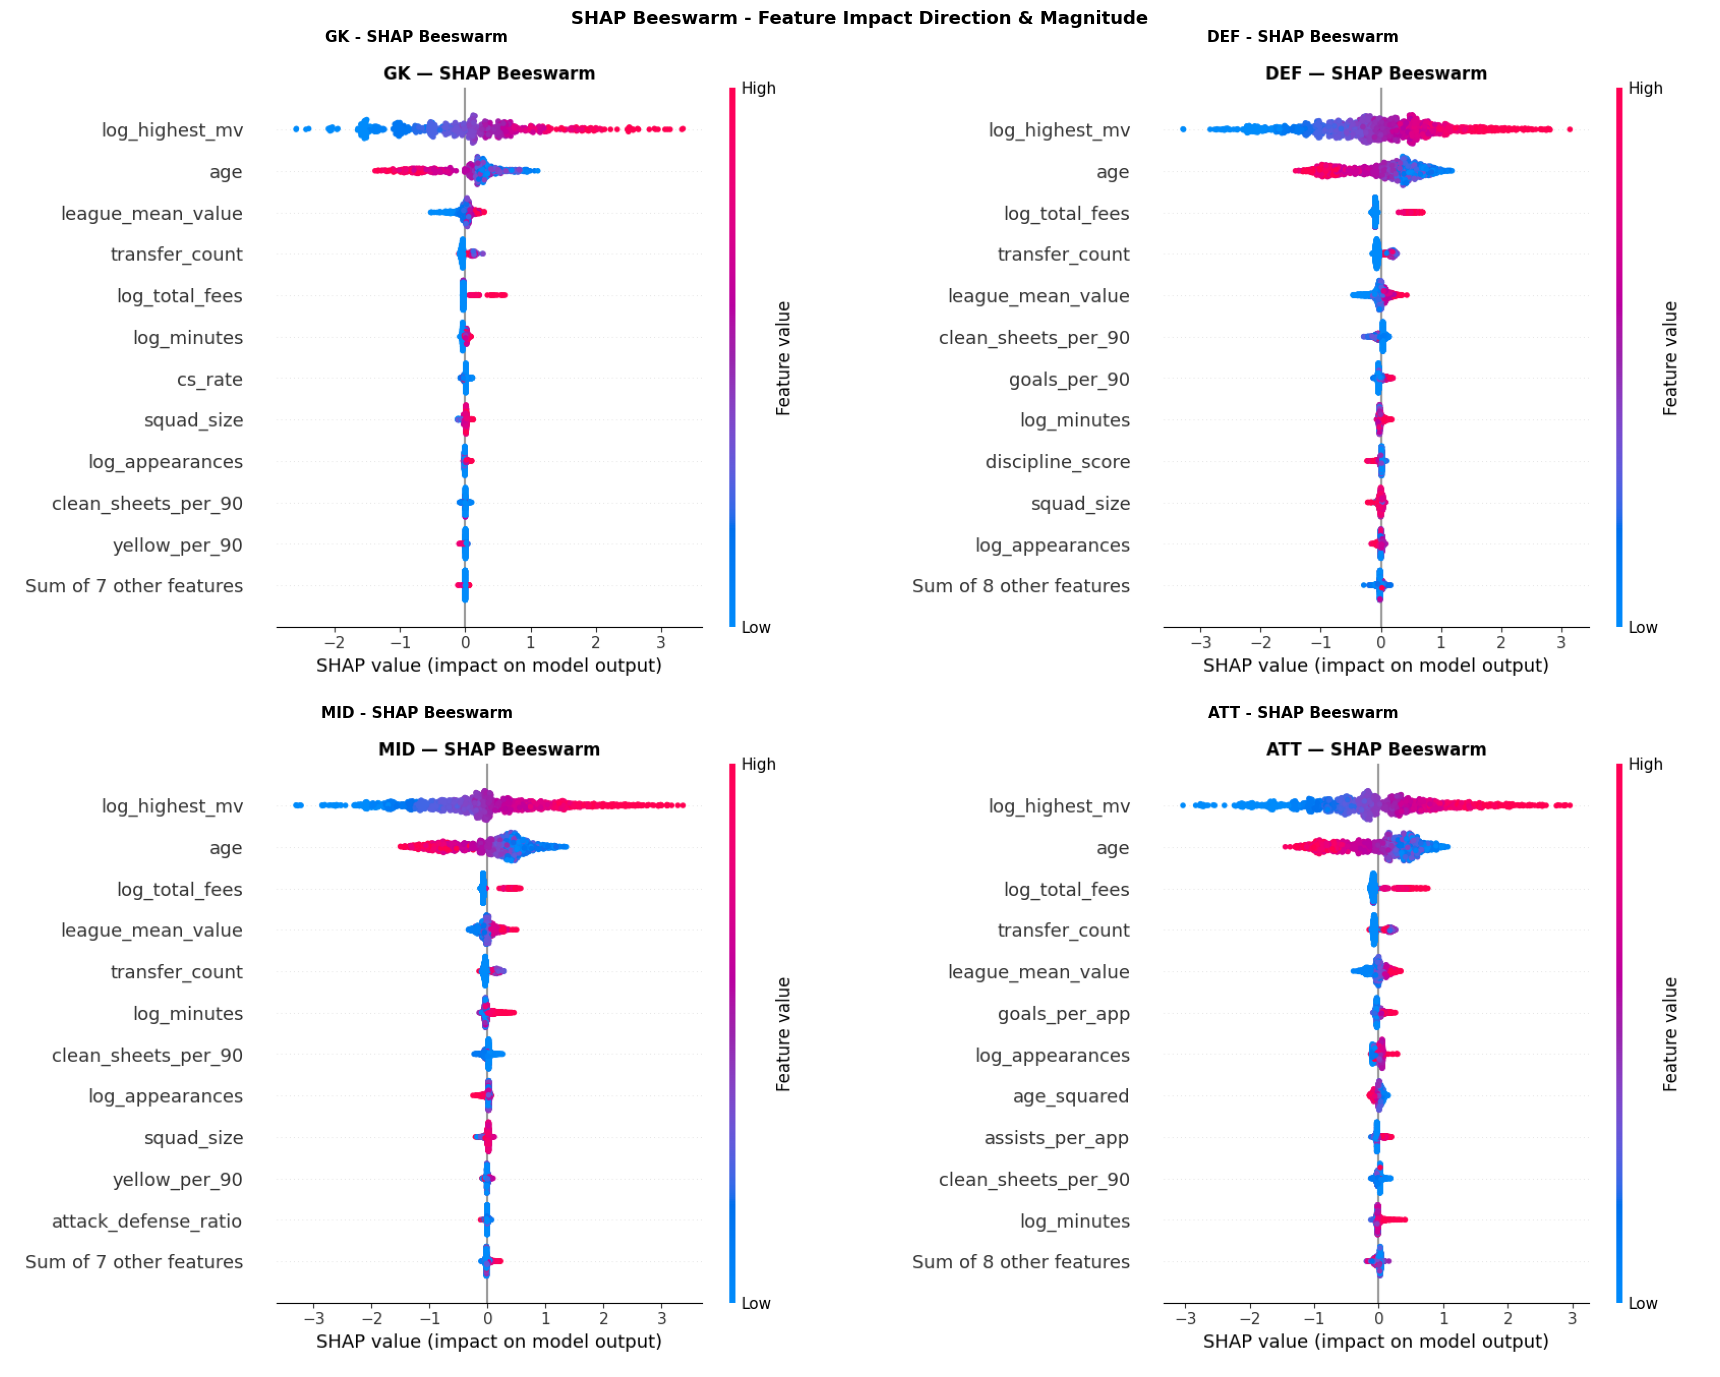

In [7]:
show_fig(FIGURES_PATH + '08_shap_bar.png',
         'SHAP: Mean |SHAP| per Feature (Global Importance)', figsize=(18, 6))

# Beeswarm 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
for ax, pos in zip(axes.flatten(), POSITIONS):
    path = FIGURES_PATH + f'08_shap_beeswarm_{pos.lower()}.png'
    if os.path.exists(path):
        ax.imshow(mpimg.imread(path)); ax.axis('off')
        ax.set_title(f'{pos} - SHAP Beeswarm', fontsize=11, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'Not available', ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')
plt.suptitle('SHAP Beeswarm - Feature Impact Direction & Magnitude',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '10_shap_beeswarm_grid.png', bbox_inches='tight')
plt.show()

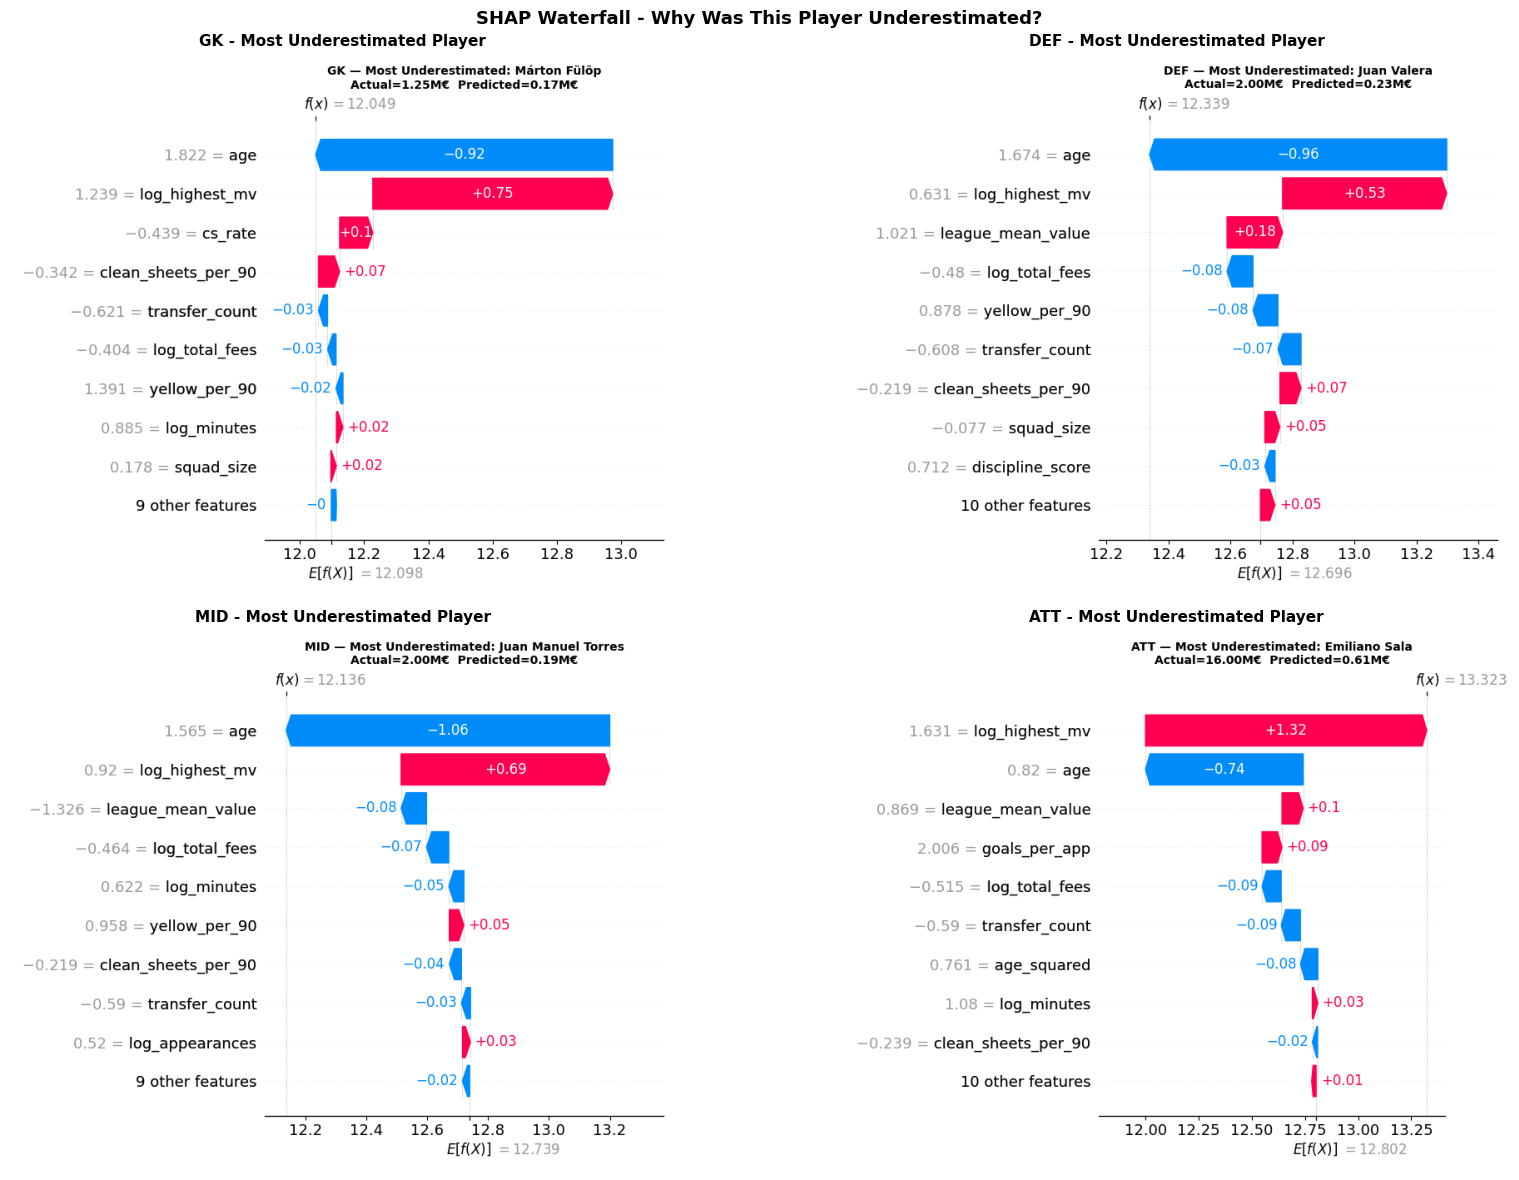

In [8]:
# Waterfall 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for ax, pos in zip(axes.flatten(), POSITIONS):
    path = FIGURES_PATH + f'08_shap_waterfall_{pos.lower()}.png'
    if os.path.exists(path):
        ax.imshow(mpimg.imread(path)); ax.axis('off')
        ax.set_title(f'{pos} - Most Underestimated Player', fontsize=11, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'Not available', ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')
plt.suptitle('SHAP Waterfall - Why Was This Player Underestimated?',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_PATH + '10_shap_waterfall_grid.png', bbox_inches='tight')
plt.show()

---
## 6. Error Analysis

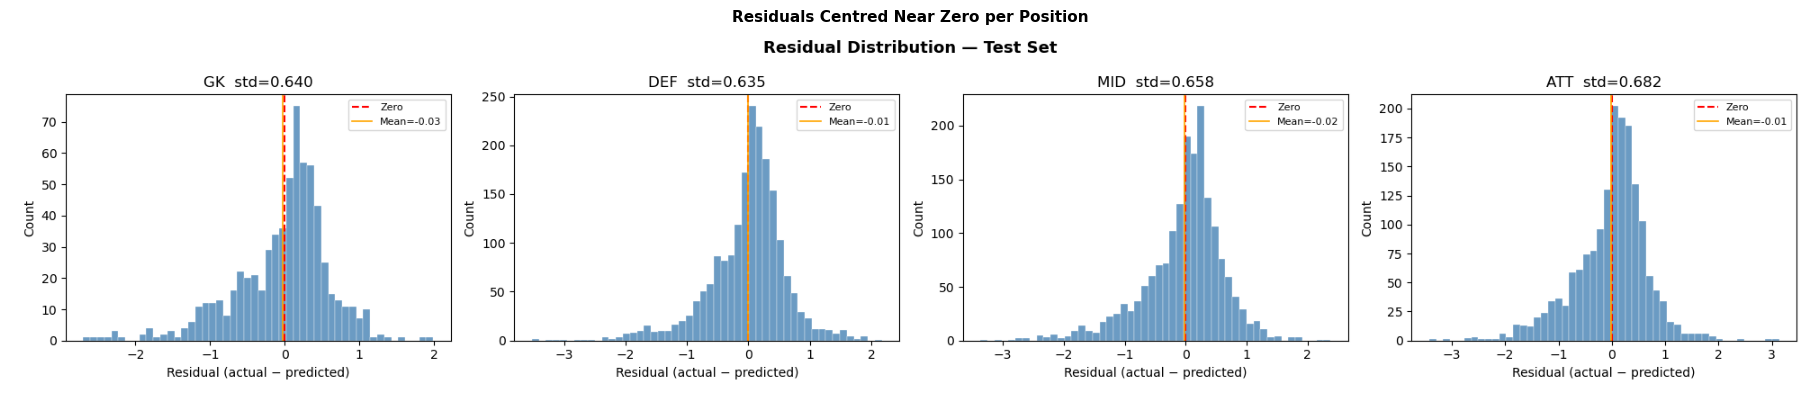

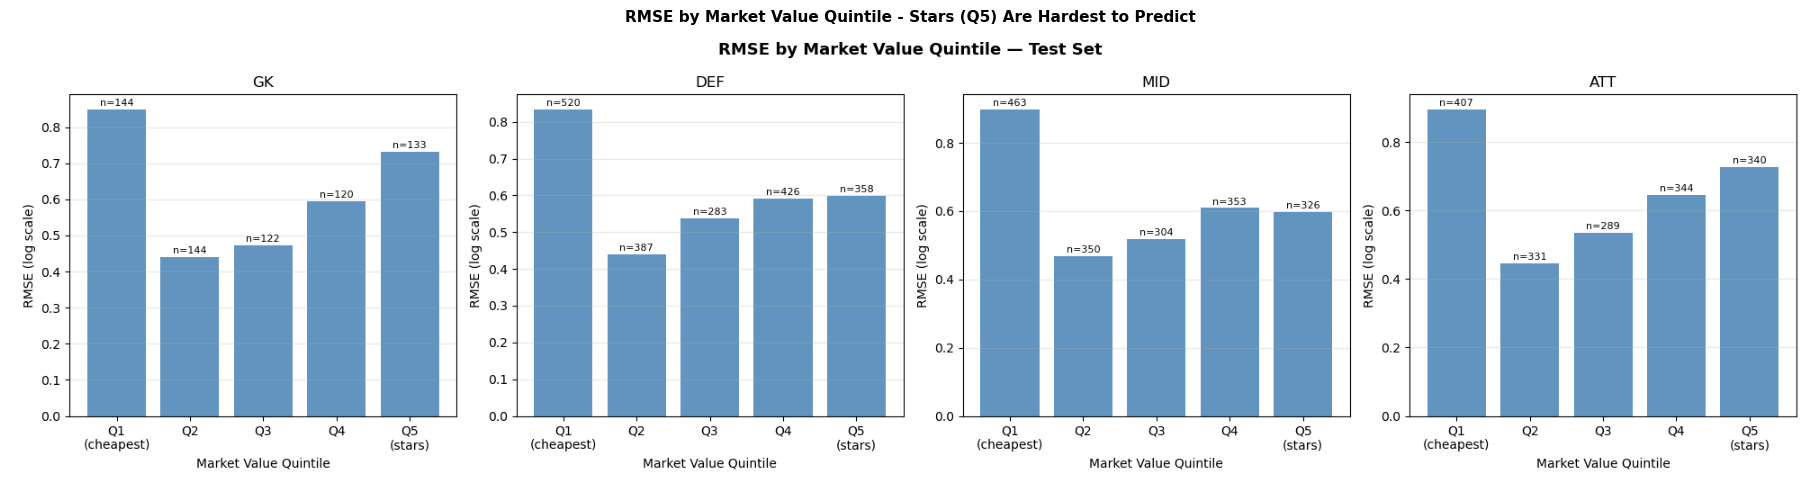

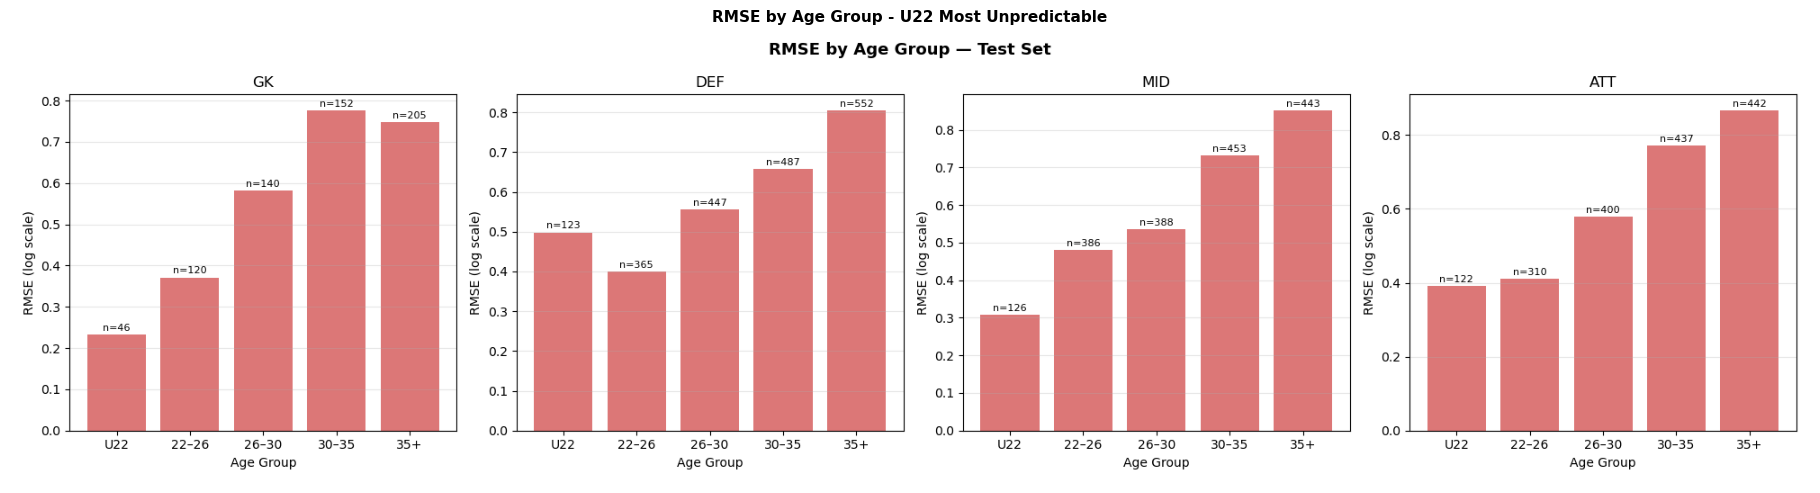

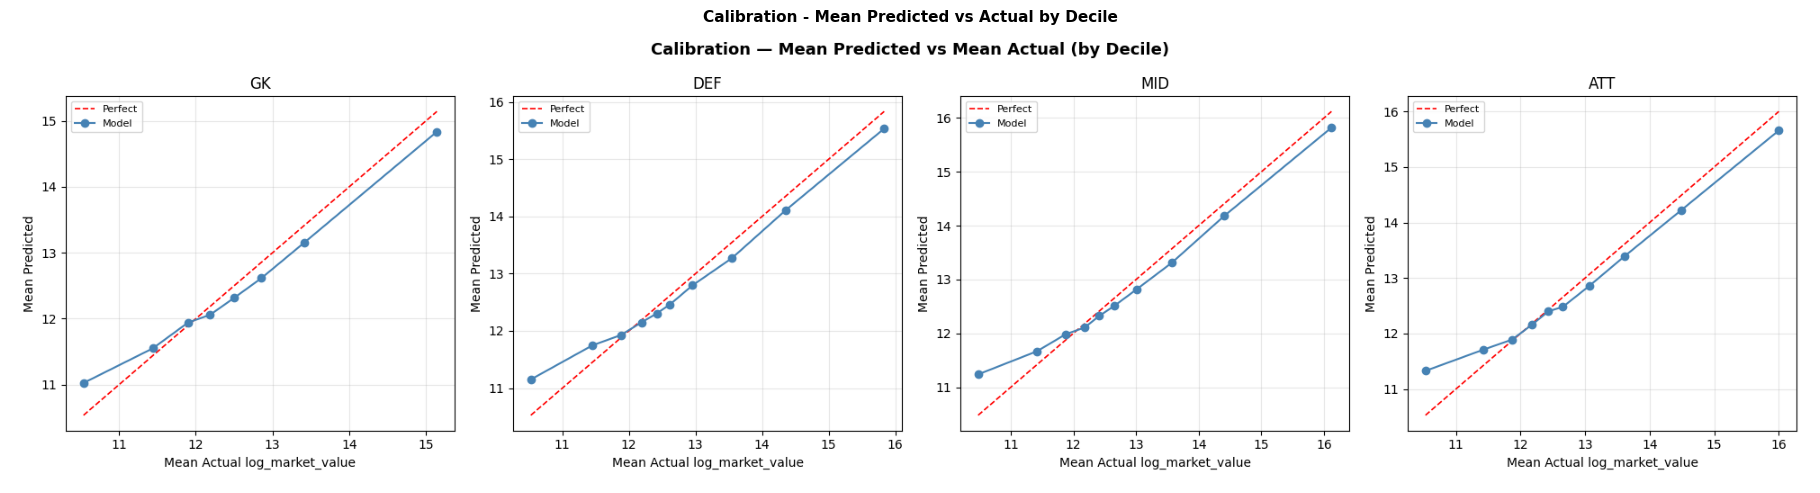

In [9]:
show_fig(FIGURES_PATH + '08_residual_distribution.png',
         'Residuals Centred Near Zero per Position', figsize=(18, 4))
show_fig(FIGURES_PATH + '08_error_by_value_range.png',
         'RMSE by Market Value Quintile - Stars (Q5) Are Hardest to Predict', figsize=(18, 5))
show_fig(FIGURES_PATH + '08_error_by_age.png',
         'RMSE by Age Group - U22 Most Unpredictable', figsize=(18, 5))
show_fig(FIGURES_PATH + '08_calibration.png',
         'Calibration - Mean Predicted vs Actual by Decile', figsize=(18, 5))

---
## 7. Business Output - Undervalued Players & Dream Team

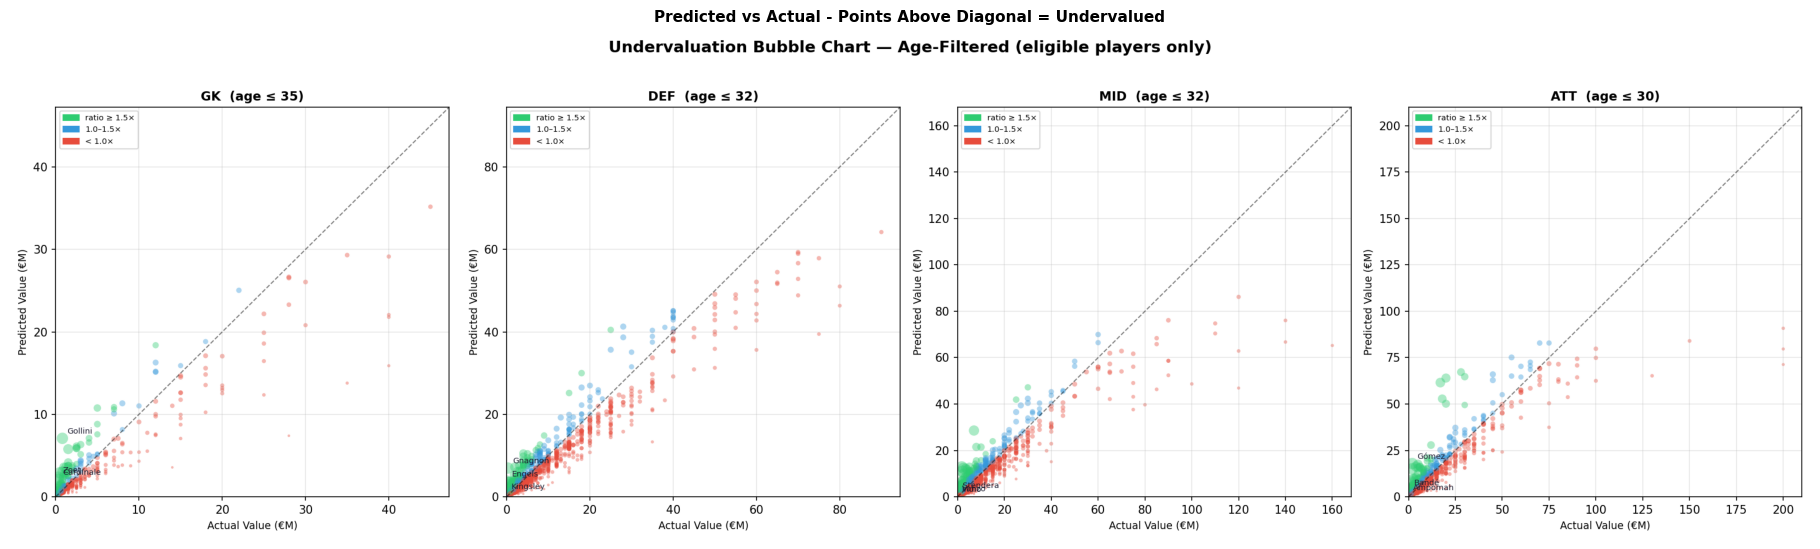

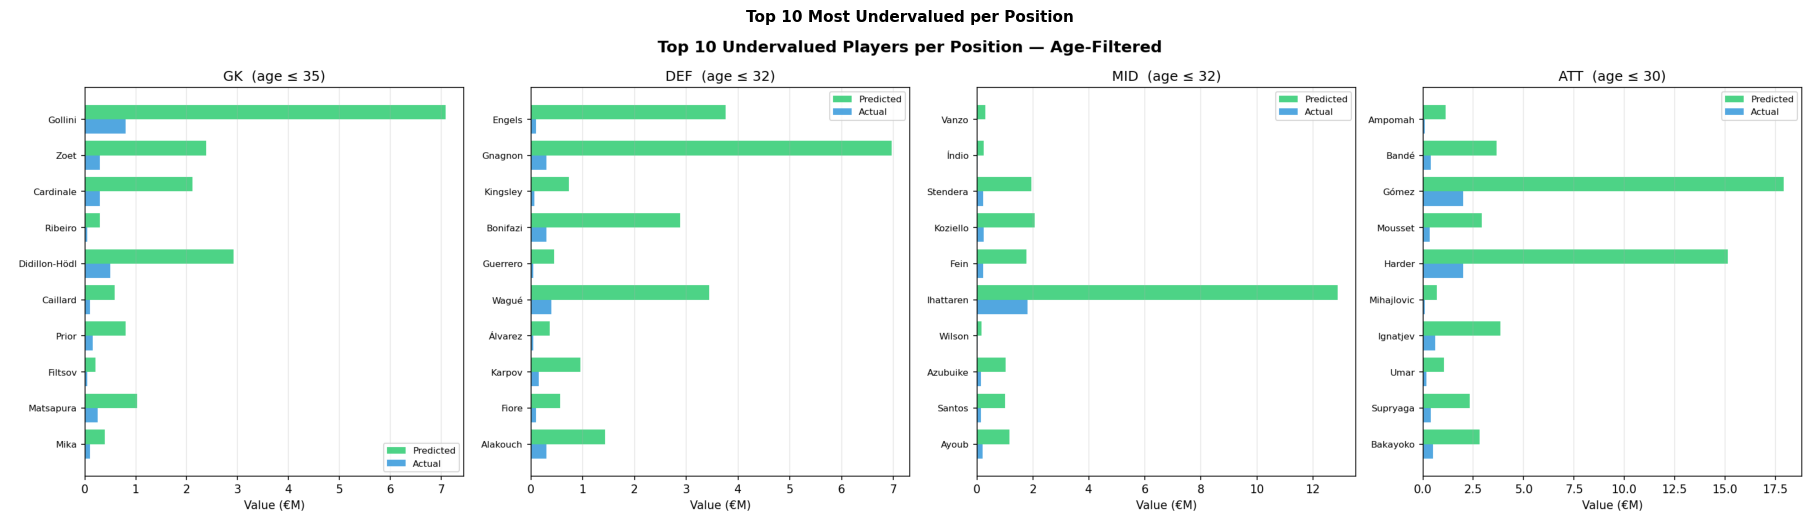

In [10]:
show_fig(FIGURES_PATH + '09_undervaluation_bubble.png',
         'Predicted vs Actual - Points Above Diagonal = Undervalued', figsize=(18, 6))
show_fig(FIGURES_PATH + '09_top_undervalued_bar.png',
         'Top 10 Most Undervalued per Position', figsize=(18, 6))

In [11]:
dream_team = pd.read_csv(PROC_PATH + 'dream_team.csv')
total_cost = dream_team['actual_value_M'].sum()
total_pred = dream_team['predicted_M'].sum()
total_gap  = dream_team['value_gap_M'].sum()

print('DREAM TEAM (4-3-3) - Most Undervalued XI')
print('=' * 72)
for pos in POSITIONS:
    print(f'\n  [{pos}]')
    for _, row in dream_team[dream_team['position_group'] == pos].iterrows():
        print(f'    {row["name"]:<28}  age={row["age"]:>2}  '
              f'actual={row["actual_value_M"]:>5.2f}M  '
              f'model={row["predicted_M"]:>5.2f}M  '
              f'ratio={row["underval_ratio"]:>5.2f}x  '
              f'({row["league"]})')
print(f'\n  Squad cost:       {total_cost:.2f}M')
print(f'  Predicted value:  {total_pred:.2f}M  ({total_pred/max(total_cost,0.01):.1f}x return potential)')
print(f'  Total value gap:  +{total_gap:.2f}M')

DREAM TEAM (4-3-3) - Most Undervalued XI

  [GK]
    Pierluigi Gollini             age=30  actual= 0.80M  model= 7.09M  ratio= 8.86x  (IT1)

  [DEF]
    Björn Engels                  age=31  actual= 0.10M  model= 3.76M  ratio=37.63x  (BE1)
    Joris Gnagnon                 age=28  actual= 0.30M  model= 6.97M  ratio=23.23x  (ES1)
    Stephen Kingsley              age=31  actual= 0.07M  model= 0.73M  ratio=10.43x  (SC1)
    Kevin Bonifazi                age=29  actual= 0.30M  model= 2.88M  ratio= 9.59x  (IT1)

  [MID]
    Floriano Vanzo                age=31  actual= 0.01M  model= 0.30M  ratio=29.77x  (BE1)
    Matheus Índio                 age=29  actual= 0.03M  model= 0.24M  ratio= 9.74x  (PO1)
    Marc Stendera                 age=30  actual= 0.23M  model= 1.94M  ratio= 8.63x  (L1)

  [ATT]
    Nana Ampomah                  age=29  actual= 0.10M  model= 1.11M  ratio=11.15x  (BE1)
    Hassane Bandé                 age=27  actual= 0.40M  model= 3.66M  ratio= 9.14x  (BE1)
    Maxi Gómez 

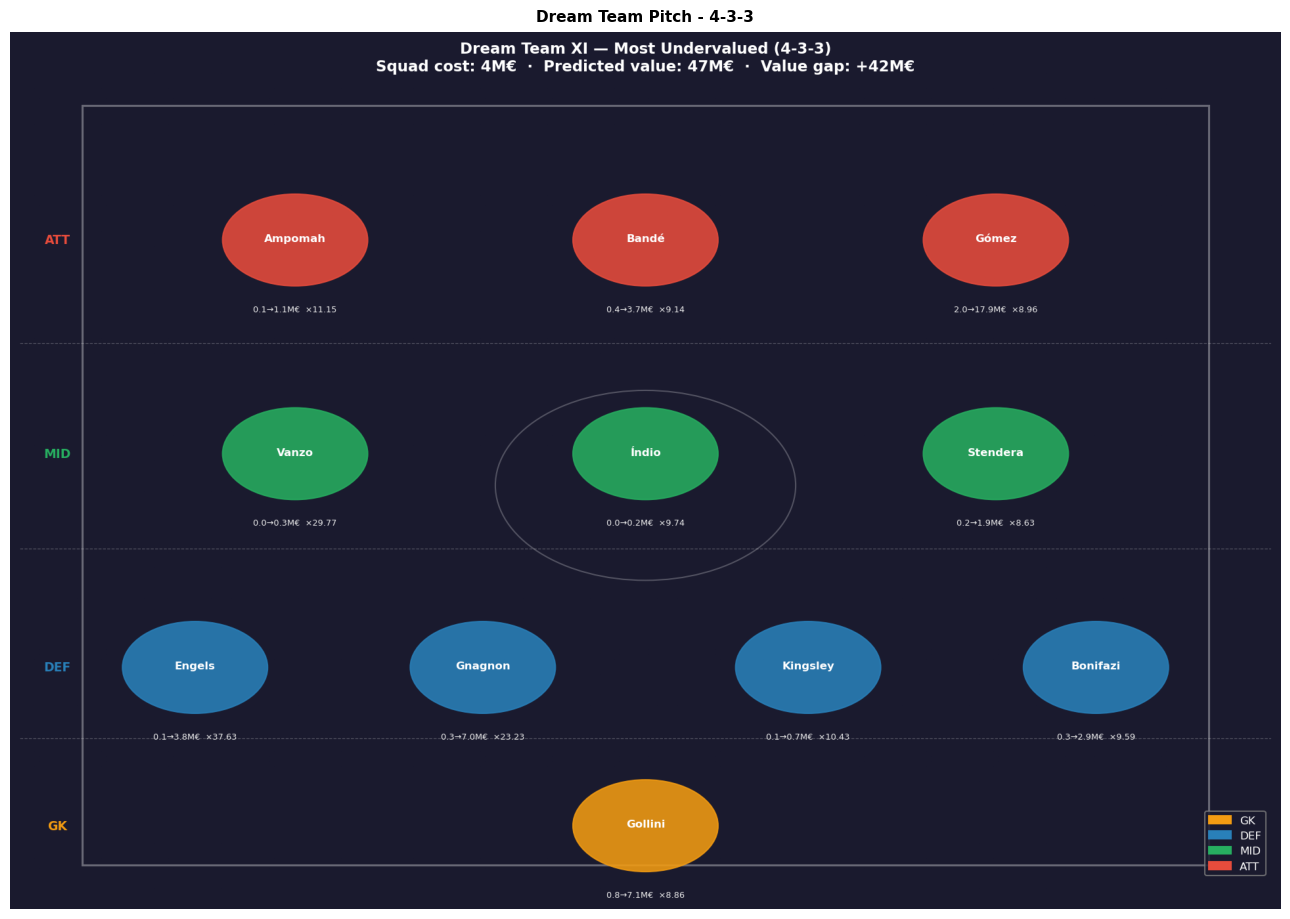

In [12]:
show_fig(FIGURES_PATH + '09_dream_team_pitch.png',
         'Dream Team Pitch - 4-3-3', figsize=(13, 9))

---
## 8. Summary Dashboard

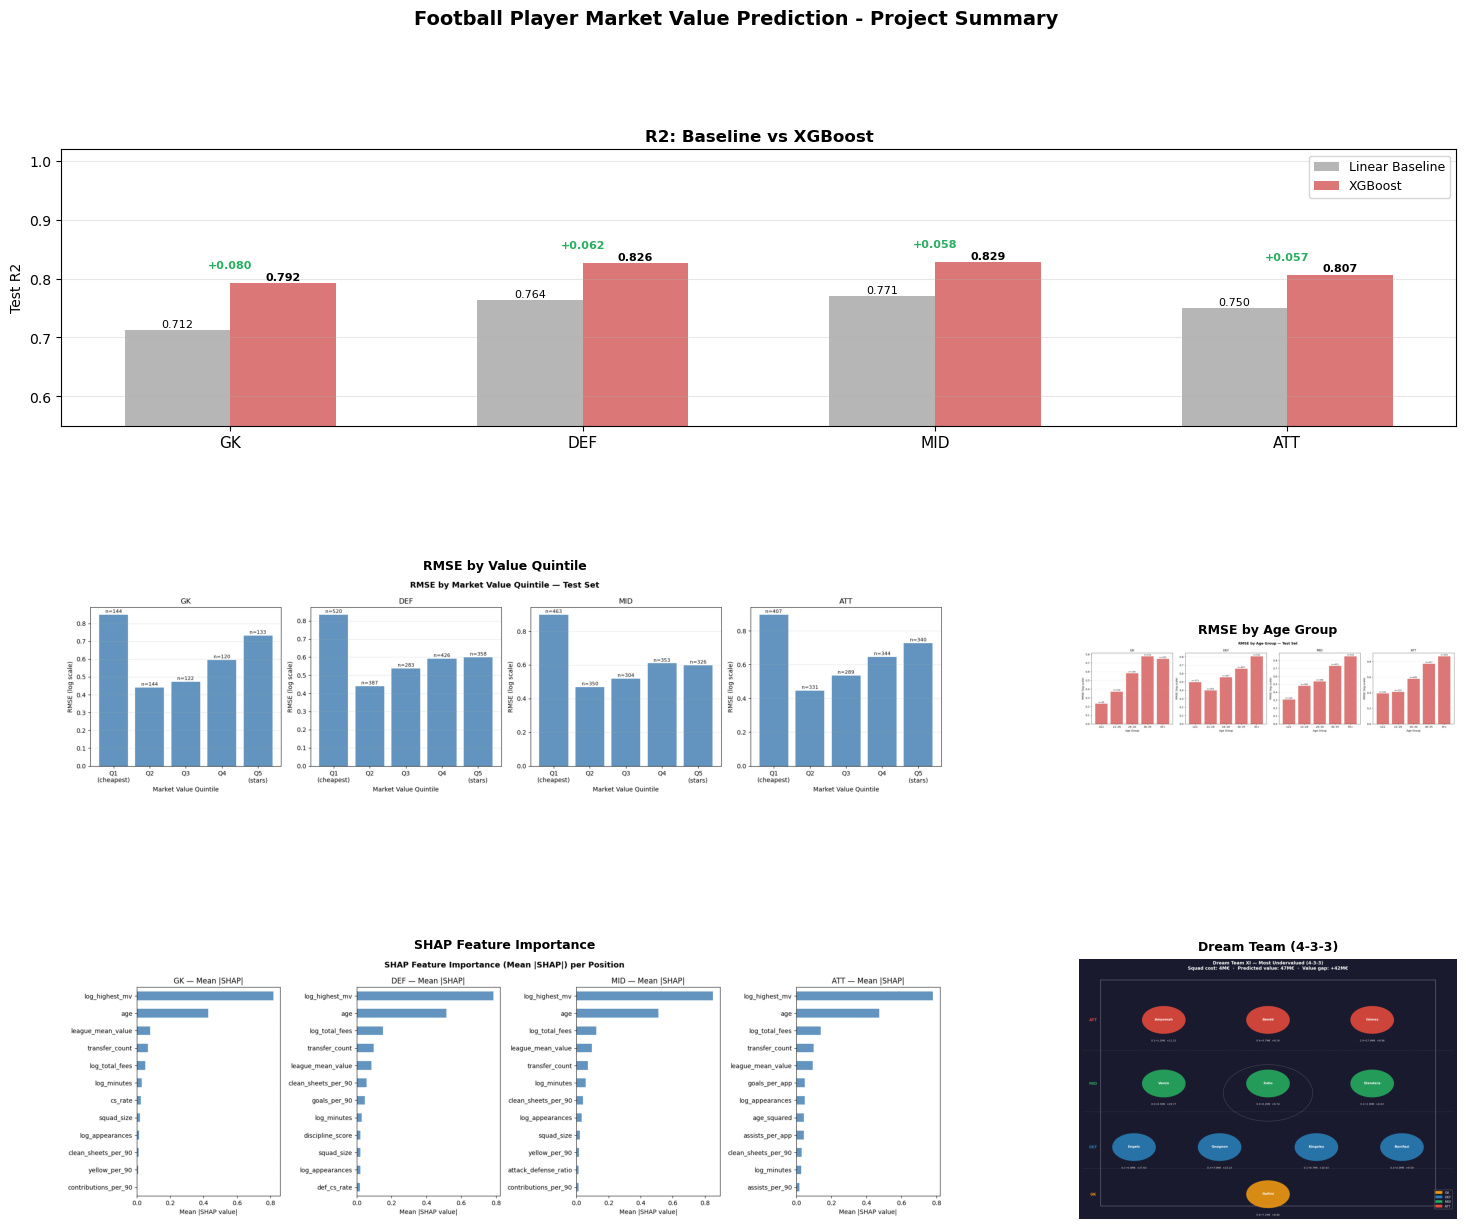

Dashboard saved.


In [13]:
fig = plt.figure(figsize=(18, 14))
gs  = gridspec.GridSpec(3, 3, figure=fig, hspace=0.45, wspace=0.35)

# Panel 1: R2 improvement
ax1 = fig.add_subplot(gs[0, :])
x, w = np.arange(len(POSITIONS)), 0.3
base  = results_df['Baseline R2'].values
final = results_df['Final R2'].values
ax1.bar(x-w/2, base,  w, label='Linear Baseline', color='#AAAAAA', alpha=0.85)
ax1.bar(x+w/2, final, w, label='XGBoost',          color='#D65F5F', alpha=0.85)
for i,(b,f) in enumerate(zip(base,final)):
    ax1.text(x[i]-w/2, b+0.005, f'{b:.3f}', ha='center', fontsize=8)
    ax1.text(x[i]+w/2, f+0.005, f'{f:.3f}', ha='center', fontsize=8, fontweight='bold')
    ax1.text(x[i], max(b,f)+0.025, f'+{f-b:.3f}', ha='center', fontsize=8,
             color='#27ae60', fontweight='bold')
ax1.set_xticks(x); ax1.set_xticklabels(POSITIONS, fontsize=11)
ax1.set_ylabel('Test R2'); ax1.set_ylim(0.55, 1.02)
ax1.set_title('R2: Baseline vs XGBoost', fontweight='bold')
ax1.legend(fontsize=9); ax1.grid(axis='y', alpha=0.3)

# Panel 2: Error by value range
ax2 = fig.add_subplot(gs[1, :2])
p = FIGURES_PATH + '08_error_by_value_range.png'
if os.path.exists(p): ax2.imshow(mpimg.imread(p))
ax2.axis('off'); ax2.set_title('RMSE by Value Quintile', fontweight='bold', fontsize=9)

# Panel 3: Error by age
ax3 = fig.add_subplot(gs[1, 2])
p = FIGURES_PATH + '08_error_by_age.png'
if os.path.exists(p): ax3.imshow(mpimg.imread(p))
ax3.axis('off'); ax3.set_title('RMSE by Age Group', fontweight='bold', fontsize=9)

# Panel 4: SHAP bar
ax4 = fig.add_subplot(gs[2, :2])
p = FIGURES_PATH + '08_shap_bar.png'
if os.path.exists(p): ax4.imshow(mpimg.imread(p))
ax4.axis('off'); ax4.set_title('SHAP Feature Importance', fontweight='bold', fontsize=9)

# Panel 5: Dream team pitch
ax5 = fig.add_subplot(gs[2, 2])
p = FIGURES_PATH + '09_dream_team_pitch.png'
if os.path.exists(p): ax5.imshow(mpimg.imread(p))
ax5.axis('off'); ax5.set_title('Dream Team (4-3-3)', fontweight='bold', fontsize=9)

fig.suptitle('Football Player Market Value Prediction - Project Summary',
             fontsize=14, fontweight='bold', y=0.98)
plt.savefig(FIGURES_PATH + '10_summary_dashboard.png', dpi=120, bbox_inches='tight')
plt.show()
print('Dashboard saved.')

---
## 9. Key Findings & Conclusions

In [14]:
all_preds = pd.read_csv(PROC_PATH + 'all_predictions.csv')

print('KEY FINDINGS')
print('=' * 60)

print('\n1. MODEL PERFORMANCE')
for _, row in results_df.iterrows():
    print(f'   {row["Position"]}: R2={row["Final R2"]:.3f}  '
          f'RMSE={row["RMSE EUR M"]:.2f}M  (+{row["R2 Gain"]:.3f} vs baseline)')

print('\n2. TOP PREDICTIVE FEATURES (SHAP + Ridge coefficients)')
print('   - log_highest_mv: prior peak value is the strongest signal')
print('   - log_minutes / log_appearances: playing time (career experience)')
print('   - league_mean_value: encodes club/league quality as single number')
print('   - age: negative effect after ~25 years old')
print('   - contributions_per_90: goals + assists per 90 min')

print('\n3. WHERE THE MODEL STRUGGLES')
print('   - Stars (Q5, >20M): highest RMSE — hype/brand value not captured')
print('   - U22 players: future potential is hard to model from stats alone')
print('   - Separate position models reduce but do not eliminate position bias')

print('\n4. RECRUITMENT INSIGHTS')
n_underval = all_preds[all_preds['underval_ratio'] > 1.5].shape[0]
total_gap  = all_preds['value_gap_M'].dropna().sum()
print(f'   {n_underval:,} players with model value >= 1.5x market price')
print(f'   Dream team 11 players cost {total_cost:.1f}M, predicted worth {total_pred:.1f}M')

print('\n5. LIMITATIONS & NEXT STEPS')
print('   - No injury history, contract status, or tactical role features')
print('   - Valuations lag real market by months (Transfermarkt update frequency)')
print('   - Future: quantile regression for confidence intervals')
print('   - Future: time-aware model (recency weighting, valuation_year feature)')
print('   - Future: richer position granularity (CB vs LB, CM vs CAM)')

KEY FINDINGS

1. MODEL PERFORMANCE
   GK: R2=0.792  RMSE=1.88M  (+0.080 vs baseline)
   DEF: R2=0.826  RMSE=1.99M  (+0.062 vs baseline)
   MID: R2=0.829  RMSE=3.99M  (+0.058 vs baseline)
   ATT: R2=0.807  RMSE=3.09M  (+0.057 vs baseline)

2. TOP PREDICTIVE FEATURES (SHAP + Ridge coefficients)
   - log_highest_mv: prior peak value is the strongest signal
   - log_minutes / log_appearances: playing time (career experience)
   - league_mean_value: encodes club/league quality as single number
   - age: negative effect after ~25 years old
   - contributions_per_90: goals + assists per 90 min

3. WHERE THE MODEL STRUGGLES
   - Stars (Q5, >20M): highest RMSE — hype/brand value not captured
   - U22 players: future potential is hard to model from stats alone
   - Separate position models reduce but do not eliminate position bias

4. RECRUITMENT INSIGHTS
   5,906 players with model value >= 1.5x market price
   Dream team 11 players cost 4.3M, predicted worth 46.6M

5. LIMITATIONS & NEXT STEPS


---
## 10. Limitations & Future Work

| Area | Limitation | Suggested Fix |
|------|------------|---------------|
| **Stars** | Q5 (>€20M) has highest RMSE — brand/hype value not captured | Log-linear correction for top percentile |
| **Young players** | U22 predictions least reliable — future potential is non-statistical | Add scouting metadata, youth academy flag |
| **Time** | No recency — a player on form right now looks same as 3 years ago | Rolling averages, `valuation_year` feature |
| **Injuries** | No injury history in dataset | Join injury records from external source |
| **Positions** | GK/DEF/MID/ATT too coarse | CB vs LB vs RB, CM vs CAM vs CDM |
| **Uncertainty** | Point estimates only | Quantile regression or conformal prediction |
| **Coverage** | 14 leagues only; players in other leagues fall back to global mean | Expand to more competitions |

In [15]:
figs = sorted([f for f in os.listdir(FIGURES_PATH) if f.endswith('.png')])
total_kb = sum(os.path.getsize(FIGURES_PATH+f)/1024 for f in figs)
print(f'Project figures: {len(figs)} files  /  {total_kb/1024:.1f} MB')
print()
for f in figs:
    nb   = f.split('_')[0]
    size = os.path.getsize(FIGURES_PATH + f) / 1024
    print(f'  {f:<45}  {size:>6.1f} KB  [nb {nb}]')

Project figures: 41 files  /  3.8 MB

  02_clubs_eda.png                                 42.8 KB  [nb 02]
  02_clubs_eda_squad_size.png                      21.7 KB  [nb 02]
  02_correlations.png                              26.2 KB  [nb 02]
  02_missing_players.png                           47.7 KB  [nb 02]
  02_outliers.png                                  42.9 KB  [nb 02]
  02_performance_distributions.png                 93.7 KB  [nb 02]
  02_player_demographics.png                       82.3 KB  [nb 02]
  02_target_distribution.png                       50.5 KB  [nb 02]
  02_transfers_eda.png                             57.5 KB  [nb 02]
  02_valuations_over_time.png                      42.0 KB  [nb 02]
  02_value_by_position.png                         49.0 KB  [nb 02]
  04_feature_correlations.png                     232.0 KB  [nb 04]
  04_multicollinearity.png                        154.4 KB  [nb 04]
  05_train_test_target_distribution.png            36.8 KB  [nb 05]
  06_actua